# Test Data Maker

This notebook creates a test dataset to feed into a trained SVM model. First, we load modules and files.

In [11]:
# Load modules 

import pickle, time, os, json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pygama import lgdo
import pygama.pargen.dsp_optimize as opt

# Set defaults for figures 
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='bright')
plt.style.use('/global/homes/e/esleon97/clint.mpl')
    
# Set directories
lgnd_data_dir = "/global/cfs/projectdirs/m2676/data/lngs/l200/public/prodenv"
run = "/phy/p03/r003/"
raw_dir = lgnd_data_dir + "/prod-orig/archive/raw-v01.00/generated/tier/raw" + run
dsp_dir = lgnd_data_dir + "/prod-blind/ref/v01.03/generated/tier/dsp" + run
hit_dir = lgnd_data_dir + "/prod-blind/ref/v01.03/generated/tier/hit" + run

# Set files
raw_files = sorted([os.path.abspath(os.path.join(raw_dir, p)) for p in os.listdir(raw_dir)])
dsp_files = sorted([os.path.abspath(os.path.join(dsp_dir, p)) for p in os.listdir(dsp_dir)])
hit_files =sorted([os.path.abspath(os.path.join(hit_dir, p)) for p in os.listdir(hit_dir)])

sto = lgdo.LH5Store()
with open('./dsp_config_dwt.json') as dsp:
    dsp_config = json.load(dsp)

# sto.gimme_file(hit_files[0], 'r')['ch1081603/hit'].keys() # Useful to look at what is in the files

Next we construct a list of **usable** Germanium detectors corresponding to the period and run we want to analyze. For this, we need configuration files from the ```legend_dataflow_config``` and ```legend_hardware_config``` repositories. The user should copy these files into the ```data``` directory.

In [12]:
# Include baseline, pulser, and muon trigger channels

ch_list = ['ch1027200', 'ch1027201', 'ch1027202']

with open('../data/l200-p03-r%-T%-all-config.json') as hw:
    hw_config = json.load(hw)
with open('../data/L200-p03-r000-T%-all-config.json') as df:
    df_config = json.load(df)

key_list = df_config['analysis'].keys()

for key in key_list:
    
    if key[0] in ['V','P','C','B']:
        if df_config['analysis'][key]['usability'] == 'on':
            rawid = 'ch' + str(hw_config[key]['daq']['rawid'])
            ch_list.append(rawid)

Here we load a specified number of cycles. Each background cycle contains about 2,000 waveforms. We need 100,000 waveforms from all detectors in total, so reading in 5 files is more than enough. 

In [13]:
n_files = 5
raw_files_in = raw_files[0:n_files]
dsp_files_in = dsp_files[0:n_files]
hit_files_in = hit_files[0:n_files]

bltrigger_dict = lgdo.load_nda(raw_files_in, ['daqenergy'], ch_list[0] + '/raw')
pulser_dict = lgdo.load_nda(raw_files_in, ['daqenergy'], ch_list[1] + '/raw')
muon_dict = lgdo.load_nda(raw_files_in, ['daqenergy'], ch_list[2] + '/raw')

Now we eliminate triggers from baseline, pulser, and muon channels.

In [14]:
idxs_pass = np.where((pulser_dict['daqenergy'] == 0) 
                     & (bltrigger_dict['daqenergy'] == 0)
                     & (muon_dict['daqenergy'] == 0))[0]

Once we remove auxiliary triggers, we can construct the test dataset. We evenly select waveforms from all usable Germanium detectors. The ```dsp_config_dwt.json``` file contains a minimal list of **dsp** processors to perform a Discrete Wavelet Transform (DWT) on the selected waveforms. We include other parameters from the **raw**, **dsp**, and **hit** tiers in the dataset as well. This step should take between 1-5 minutes, depending on how many files we load in. 

In [15]:
import logging, sys
logging.disable(sys.maxsize) #ignore logger warnings

dwt_norm_list, wf_norm_list, daqenergy_list, channel_list =  [], [], [], []
trapEmax_ctc_cal_list, cuspEmax_ctc_cal_list = [], []
is_valid_0vbb_list, is_neg_energy_list = [], []
is_valid_baseline_list, is_valid_tail_list = [], []
is_noise_burst_list = []

n_max = round(100000/len(ch_list[3:]))

start_time = time.time()
    
for ch in ch_list:

    if ch in ['ch1027200', 'ch1027201', 'ch1027202']:
        continue

    tb_raw, n_raw = sto.read_object(ch + '/raw', raw_files_in, idx=idxs_pass, n_rows=n_max)
    tb_dsp, n_dsp = sto.read_object(ch + '/dsp', dsp_files_in, idx=idxs_pass, n_rows=n_max)
    tb_hit, n_hit = sto.read_object(ch + '/hit', hit_files_in, idx=idxs_pass, n_rows=n_max)
    tb_dwt = opt.run_one_dsp(tb_raw, dsp_config)
    
    # print(ch, n_raw, n_dsp, n_hit) # Useful to check if enough events are being read
    
    daqenergy, channel = tb_raw['daqenergy'].nda, tb_raw['channel'].nda
    dwt_norm, wf_norm = tb_dwt['dwt_norm'].nda, tb_dwt['wf_norm']['values'].nda
    trapEmax_ctc_cal = tb_hit['trapEmax_ctc_cal'].nda
    cuspEmax_ctc_cal = tb_hit['cuspEmax_ctc_cal'].nda
    is_valid_0vbb = tb_hit['is_valid_0vbb'].nda
    is_neg_energy = tb_hit['is_neg_energy'].nda
    is_valid_baseline = tb_hit['is_valid_baseline'].nda
    is_valid_tail = tb_hit['is_valid_tail'].nda
    is_noise_burst = tb_hit['is_noise_burst'].nda


    for i in range(len(daqenergy)):

        daqenergy_list.append(daqenergy[i])
        channel_list.append(channel[i])
        dwt_norm_list.append(dwt_norm[i])
        wf_norm_list.append(wf_norm[i])
        trapEmax_ctc_cal_list.append(trapEmax_ctc_cal[i])
        cuspEmax_ctc_cal_list.append(cuspEmax_ctc_cal[i])
        is_valid_0vbb_list.append(is_valid_0vbb[i])
        is_neg_energy_list.append(is_neg_energy[i])
        is_valid_baseline_list.append(is_valid_baseline[i])
        is_valid_tail_list.append(is_valid_tail[i])
        is_noise_burst_list.append(is_noise_burst[i])
        

print("--- %s minutes  elapsed ---" % ((time.time() - start_time)/60))

--- 3.589524296919505 minutes  elapsed ---


We now save the waveforms, DWTs, and other parameters into a data dictionary. We also look at the energy spectrum of the dataset and at sample waveforms as a sanity check.

In [20]:
data_dict = {
    "dwt_norm": np.array(dwt_norm_list),
    "wf_norm": np.array(wf_norm_list),
    "daqenergy": np.array(daqenergy_list),
    "channel": np.array(channel_list),
    "trapEmax_ctc_cal": np.array(trapEmax_ctc_cal_list),
    "cuspEmax_ctc_cal": np.array(cuspEmax_ctc_cal_list),
    "is_valid_0vbb": np.array(is_valid_0vbb_list),
    "is_neg_energy": np.array(is_neg_energy_list),
    "is_valid_baseline": np.array(is_valid_baseline_list),
    "is_valid_tail": np.array(is_valid_tail_list),
    "is_noise_burst": np.array(is_noise_burst_list)
}

(100035,)


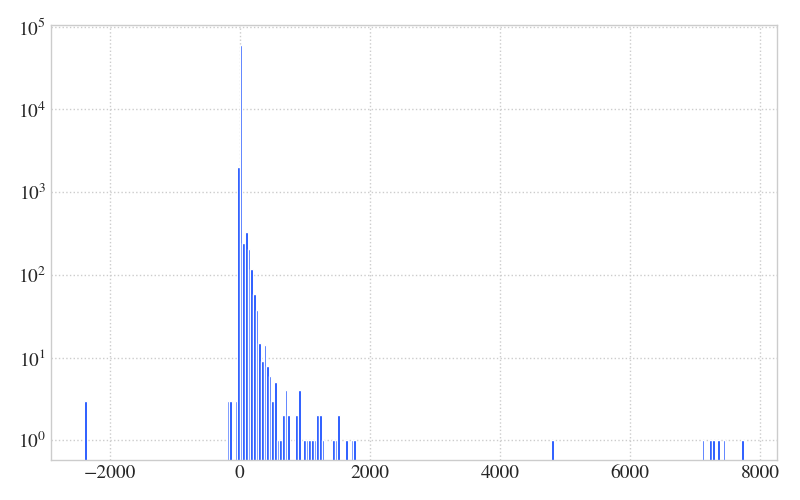

In [17]:
%matplotlib widget

plt.hist(data_dict['cuspEmax_ctc_cal'], bins=250)
plt.yscale('log')
print(data_dict['cuspEmax_ctc_cal'].shape)

(1204,)


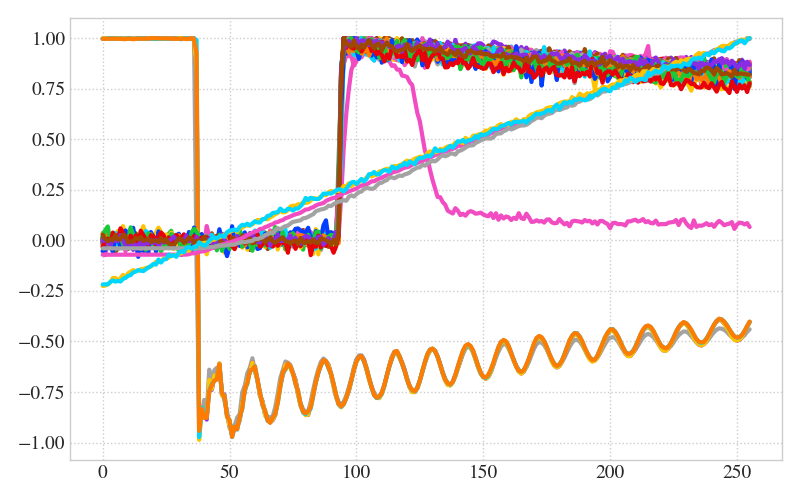

In [18]:
%matplotlib widget
fig, ax = plt.subplots(1,1)

sel = np.where(data_dict['daqenergy'] > 0)[0]
print(sel.shape)
for i in sel[0:100]:
    ax.plot(data_dict['dwt_norm'][i])

In [21]:
with open('p03_r003_test_data.pickle', 'wb') as handle:
    pickle.dump(data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)